In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy import modeling
from scipy.optimize import curve_fit
#from ROHSApy import ROHSA


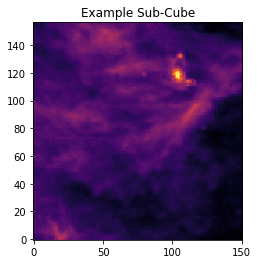

In [2]:
fitsname = "GHIGLS_UMA_Tb.fits"
hdu = fits.open(fitsname)
hdr = hdu[0].header
cube = hdu[0].data[0]

#The data from the cube was plotted
plt.figure()
plt.imshow(np.sum(cube,0), origin="lower", cmap="inferno")
plt.title('Example Sub-Cube')
plt.savefig('subcube.pdf')
plt.show()


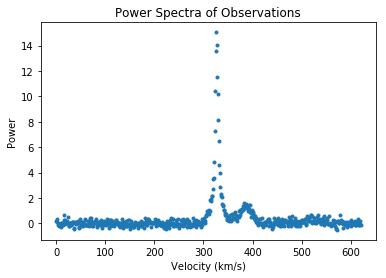

In [3]:
#the spectrum from a single pixel was plotted

# frame = hdu[0].data[0][400,:1,:1]
# dat = hdu[0].data

plt.plot(cube[:,0,0], linestyle = "none", marker = '.')
plt.title("Power Spectra of Observations")
plt.xlabel("Velocity (km/s)")
plt.ylabel("Power")
plt.show()

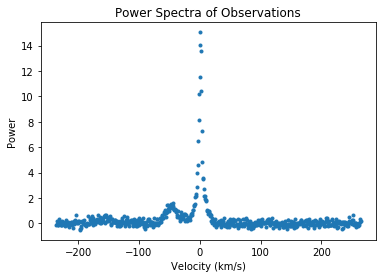

In [4]:
#the velocities were corrected by the information in the fits files, and were centered at zero

CRVAL = hdr['CRVAL3']
CDELT = hdr['CDELT3']
CRPIX = hdr['CRPIX3']

ind_array = np.arange(cube.shape[0])

v = (CRVAL + CDELT*((ind_array) - CRPIX))/1000

plt.plot(v, cube[:,0,0], linestyle = "none", marker = '.')
plt.title("Power Spectra of Observations")
plt.xlabel("Velocity (km/s)")
plt.ylabel("Power")
plt.savefig('powerspec.pdf')
plt.show()


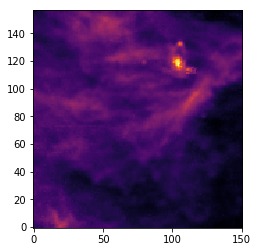

In [5]:
#The column density from equation 2

col_den = 1.823*(10**18)*np.sum(cube, 0)

plt.figure()
plt.imshow(col_den, origin="lower", cmap="inferno")
plt.show()





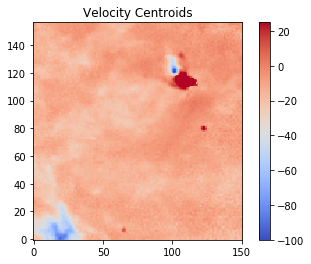

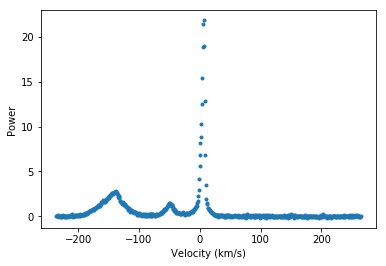

In [6]:
#centroid velocity from equation 4

v_cent = np.tensordot(cube, v, axes = (0,0))/np.sum(cube, 0)

plt.figure()
plt.imshow(v_cent, origin="lower", cmap="coolwarm", vmin = -100, vmax = 25)
plt.title("Velocity Centroids")
plt.colorbar()
plt.show()


#the average spectrum of the pixel at (100, 125) was plotted to show the presence of the galaxies m81 and m82
plt.plot(v, cube[:, 125, 100], linestyle = "none", marker = '.')
plt.xlabel("Velocity (km/s)")
plt.ylabel("Power")
plt.show() 



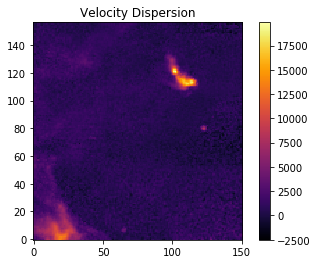

In [7]:
#velocity dispersion from equation 6

v_dis = np.tensordot(cube, v**2, axes = (0,0))/np.sum(cube, 0)

plt.figure()
plt.imshow(v_dis, origin="lower", cmap="inferno")
plt.title("Velocity Dispersion")
plt.colorbar()
plt.show()

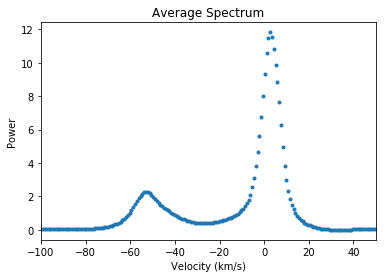

In [8]:
#Same Process but velocity was divided into 2 ranges

#the velocities were plotted over the mean of the spectrum to find where the minimum is between the two main peaks
mean_spec = np.mean(cube, (1,2))

plt.plot(v, mean_spec, linestyle = "none", marker = '.')
plt.title("Average Spectrum")
plt.xlim(-100, 50)
plt.xlabel("Velocity (km/s)")
plt.ylabel("Power")
plt.show() 



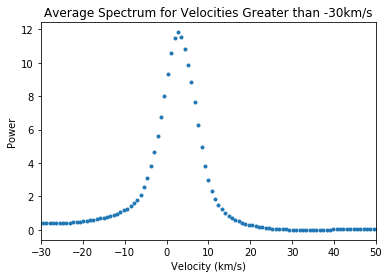

In [9]:
#now that we can see where the minimum in between the two peaks is at roughly -30 km/s,
#we will split the data at -30km/s to get more reasonable results, 

#so the first range will be velocities less than -30 km/s
#we will do this by splitting the array at -30

#first we look for the index where the velocity is less than -30 km/s

v_ind = np.where(v <= -30)

#therefore we can split all of the data sets at the index 365 to get the two distinct velocity ranges

#so for the values greater than -30km/s, the average spectrum is
v_high = v[:365]
mean_spec_high = mean_spec[:365]

plt.plot(v_high, mean_spec_high, linestyle = "none", marker = '.')
plt.title("Average Spectrum for Velocities Greater than -30km/s")
plt.xlim(-30, 50)
plt.xlabel("Velocity (km/s)")
plt.ylabel("Power")
plt.show() 



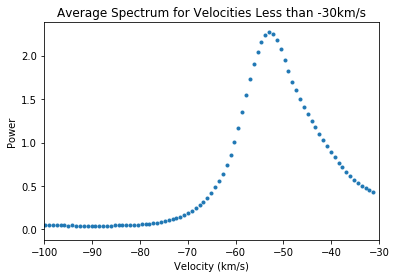

In [10]:
#for the values less than -30 km/s, the average spectrum is

v_low = v[366:]
mean_spec_low = mean_spec[366:]

plt.plot(v_low, mean_spec_low, linestyle = "none", marker = '.')
plt.title("Average Spectrum for Velocities Less than -30km/s")
plt.xlim(-100, -30)
plt.xlabel("Velocity (km/s)")
plt.ylabel("Power")
plt.show() 

In [11]:
#next we can measure the noise at the end channels. To do this, i will take the mean power over 20 points at each end

noise_low = np.mean(mean_spec[580:620])
print("The noise on the left end of the spectrum is ", noise_low)

noise_high = np.mean(mean_spec[0:40])
print("The noise on the right end of the spectrum is ", noise_high)


The noise on the left end of the spectrum is  -0.0035487313
The noise on the right end of the spectrum is  0.0021385378


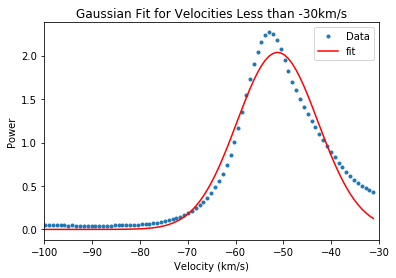

In [24]:
#now we have to fit gaussians to each individual peak in their respective ranges. To do this we will using scipy

#first we will fit the lower velocity structure using a 1D Gaussian

#fitter = modeling.fitting.LevMarLSQFitter()
#model = modeling.models.Gaussian1D()  
#fitted_model = fitter(model, v_low, mean_spec_low)

mean = sum(v_low * mean_spec_low) / sum(mean_spec_low)
sigma = np.sqrt(sum(mean_spec_low * (v_low - mean)**2) / sum(mean_spec_low))

def Gauss1(v_low, a, x0, sigma):
    return a * np.exp(-(v_low - x0)**2 / (2 * sigma**2))

popt1,pcov1 = curve_fit(Gauss1, v_low, mean_spec_low, p0=[max(mean_spec_low), mean, sigma])

plt.plot(v_low, mean_spec_low, linestyle = "none", marker = '.', label = "Data")
plt.plot(v_low, Gauss1(v_low, *popt1), 'r-', label='fit')
plt.title("Gaussian Fit for Velocities Less than -30km/s")
plt.xlabel("Velocity (km/s)")
plt.ylabel("Power")
plt.xlim(-100, -30)
plt.legend()
plt.show() 


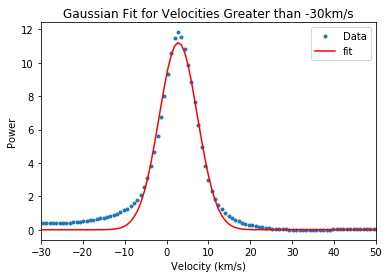

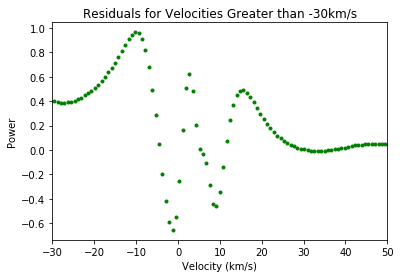

In [30]:
#next we will fit the higher velocity structure using a 1D Gaussian

#fitter = modeling.fitting.LevMarLSQFitter()
#model = modeling.models.Gaussian1D()  
#fitted_model = fitter(model, v_low, mean_spec_low)

mean = sum(v_high * mean_spec_high) / sum(mean_spec_high)
sigma = np.sqrt(sum(mean_spec_high * (v_high - mean)**2) / sum(mean_spec_high))

def Gauss2(v_high, a, x0, sigma):
    return a * np.exp(-(v_high - x0)**2 / (2 * sigma**2))

popt2,pcov2 = curve_fit(Gauss2, v_high, mean_spec_high, p0=[max(mean_spec_high), mean, sigma])

plt.plot(v_high, mean_spec_high, linestyle = "none", marker = '.', label = "Data")
plt.plot(v_high, Gauss2(v_high, *popt2), 'r-', label='fit')
plt.title("Gaussian Fit for Velocities Greater than -30km/s")
plt.xlabel("Velocity (km/s)")
plt.ylabel("Power")
plt.xlim(-30, 50)
plt.legend()
plt.show()

#now we can plot the residuals between the fit and the data itself

plt.plot(v_high, mean_spec_high - Gauss2(v_high, *popt2), linestyle = "none", marker = '.', color = 'green', label = "Data")
plt.title("Residuals for Velocities Greater than -30km/s")
plt.xlabel("Velocity (km/s)")
plt.ylabel("Power")
plt.xlim(-30, 50)
plt.show()


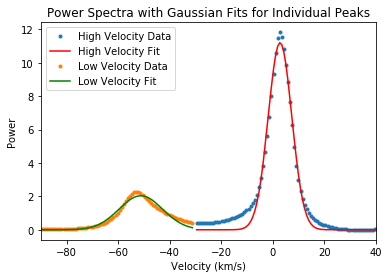

In [29]:
plt.plot(v_high, mean_spec_high, linestyle = "none", marker = '.', label = "High Velocity Data")
plt.plot(v_high, Gauss2(v_high, *popt2), 'r-', label='High Velocity Fit')

plt.plot(v_low, mean_spec_low, linestyle = "none", marker = '.', label = "Low Velocity Data")
plt.plot(v_low, Gauss1(v_low, *popt1), 'g-', label='Low Velocity Fit')
plt.title("Power Spectra with Gaussian Fits for Individual Peaks")
plt.xlabel("Velocity (km/s)")
plt.ylabel("Power")
plt.xlim(-90, 40)
plt.legend()
plt.savefig('gaussianfit.pdf')
plt.show()